# Projet d'optimisation pour du "task offloading" avec Levy Flight

## Problème d'optimisation

Le problème d'optimisation fait suite à l'amélioration exponentielle du Big Data, (IOT, véhicules autonomes ...) qui font que le nombre de données en temps réel est de plus en plus important. Le nombre de données en temps réel (flux) devant être traitées rapidement a explosé.

Les clouds fournient de nombreuses ressources pour des calculs massifs. Cependant, les clouds centralisées sont surchargés par les flux de données, ce qui entraîne une consommation d'énergie importante et des retards.

C'est pour cette raison que l'on utilise désormais le fog computing, dont l'architecture permet de déterminer où le calcul doit être effectué : sur la machine locale, sur le fog layer ou sur le cloud. Le fog layer comprend des
routeurs, des commutateurs et des micro-serveurs (fog node) qui sont plus proches de la machine locale que le cloud, et qui peuvent être utilisés par les utilisateurs. 

Notre objectif est de développer un programme qui associe les fognode fN aux tâches à effectuer.

Nous avons pour cela modéliser notre problème comme suit :

$$\min\limits_{X_i} \sum\limits_{i = 1}^N X_i\frac{P_i-P^{min}}{P^{max}-P^{min}}$$
$$\min\limits_{X_i} \sum\limits_{i = 1}^N X_i\frac{D_i-D^{min}}{D^{max}-D^{min}}$$
$$ s.t. \sum\limits_{i = 1}^N X_i-M=0$$
$$\sum\limits_{i = 1}^N \frac{B_i}{B_{i,S}} \quad \quad - 1 < 0 \\$$
$$W_j \in [0,1], \forall j \in \{1, 2, 3\}\\$$
$$T_{j,i} \in [0,1], \forall j \in \{1, 2, 3\}, \forall i \in [\![1, N]\!]\\$$
$$X_i \in \{0,1\}, \forall i \in [\![1, N]\!]\\$$

$P_i = P_i*\frac{l\tau_i}{f_i}$ la puissance pour traiter l bit de donnée sachant que 1 bit de donnée est traités sur $\tau_i$ cycle de CPU sur la fréquence du CPU (afin de déterminer le temps de calcul nécessaire pour l bits) fois la puissance requise pour un cycle $P_i*$. $P^{min}$ et $D^{min}$ représentent respectivement les FN de tout le système avec la plus petite puissance consommé et le retard le plus court, à l'inverse, $P^{max}$ et $D^{max}$ représentent respectivement les FN de tout le système avec la plus grande puissance consommé et le retard le plus long, le but est de normalisé les valeurs. 

$D_i$ est déterminé avec des courbe de service d'entré et de sortie déterminé par du calcul de réseau.

La première fonction objectif permet de minimiser la puissance consommé lors dans l'assignation. La seconde contrainte est la minimisation du retard totale du système. La première contrainte permet d'allouer exactement M FN au M taches. La quatrième permet de vérifier que la taille de traitement d'opération disponible dans le FN (buffer $B_{i,S}$) est suffisante pour traiter la taille de la tache $B_i$. 

Or ce problème suppose que le problème d'allocation d'une tache à un FN signifie que tous les FN ne seront pas alloué et que toutes les tâches soient les mêmes, c'est à dire : pour 4 sous taches répparti sur 7 FN disponibles, je dois trouver une solution de la forme [1, 1, 1, 1, 0, 0, 0] optimal. Cependant, nous voyons clairement sur la recherche que pour des FN identiques assignés à des tâches différentes, la valeur d'assignement est différente : 


<img src="table_assignement_FN.PNG" alt="assignement FN" height="300" />

Ce qui signifie que chaque tâches réparties entre les FN ont des caractéristiques différentes.

C'est pour cette raison que nous cherchons plutôt à modéliser les solutions sous la forme d'un tableau de toutes les tâches alloués au FN choisi de la forme [FN1, FN3, FN4, FN2, FN1] ou le premier indice indique la première tâche et le nième indice indique la nième tâche.

Nous pouvons donc réécrire le problème :

$$\min\limits_{X_{i,j}} \sum\limits_{i = 1}^N X_{i,j}P_{i,j}$$
$$\min\limits_{X_{i,j}} \sum\limits_{i = 1}^N X_{i,j}D_{i,j}$$
$$ s.t. \sum\limits_{i = 1}^N X_{i,j}-M=0$$
$$\sum\limits_{i = 1}^N \frac{B_{i,j}}{B_{i,j,S}} \quad \quad - 1 < 0 \\$$
$$\sum\limits_{i = 1}^N X_{i,j} = \sum\limits_{j = 1}^M X_{i,j} = 1\\$$
$$X_i \in \{0,1\}, \forall i \in [\![1, N]\!]\\$$


Ainsi nous travaillerons sur un environnement similaire fournis par les tableau de Cost et de temps d'éxecution. Nous supposerons aussi que la contrainte du buffer est naturellement respectée.

## Algorithme d'optimisation Monarch

Cet algorithme s'inspire du comportement migratoire des papillons Monarques lorsqu'ils doivent s'orienté dans de nouveaux environnement en suivant certain individus qui ont de meilleurs probabilité de s'orienter. En imitant ce comportement, notre algorithme cherche à garder une mémoire au long terme sur les comportements à adopter.

<img src="migration_monarque.jpg" alt="migration monarque" height="300" />

L'algorithme monarque est clairement utilisé pour des problèmes d'optimisation à variables réelles.
Pour faire correspondre l'algorithme Monarch au problème spécifique, Nous avons défini les étapes de process comme suit :

MONARCH :
- Créer N solutions possibles réuni dans une population
- diviser N dans deux sous populations NP1 et NP2
- pour chaque élément de chaque solution sur NP1 :
    1 - générer  un nombre aléatoirement sur une loi uniforme 
    2 - comparer ce nombre a une variable p fixée
        - si p est supérieur: copier un élément d'une autre solution de NP1 sur l'élément actuel
        - si p est inférieur: copier un élément d'une autre solution de NP2 sur l'élément actuel
- pour chaque élément de chaque solution de NP2:
     1 - générer  un nombre aléatoirement sur une loi normal 
     2 - comparer ce nombre a une variable p fixée
        - si p est supérieur: copier l'élément de la meilleur solution de toute la population sur l'élément actuel
        - si p est inférieur: copier un élément d'une autre solution de NP2 sur l'élément actuel
- Évaluer les nouvelles solutions
- Générer une nouvelle population avec toutes les solutions des rangs les moins dominés
- Critère d'arrêt : itération d'algorithme

La principale caractéritisque de cette méthode est la probabilité de copier des éléments venant directement d'une des meilleure solutions (du front pareto ou du rang le plus proche du front pareto) garantissant la mémoire à long terme des mouvements à effectuer.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import time

## Deux datasets CostTable et ExecutionTable

CostTable représente le cout énergétique d'éxécuter chaque tâche sur chacun des FN.

ExecutionTable représente le délai d'éxecution de chaque tâche sur chaque FN.



In [2]:
cost_table = np.genfromtxt('CostTable40.csv', delimiter=',', skip_header=1)
cost_table = cost_table[:, 1:] # clean le dataset
execution_table = np.genfromtxt('ExecutionTable40.csv', delimiter=',', skip_header=1)
execution_table = execution_table[:, 1:] # clean le dataset

On génère une population de façon aléatoire, dans chaque individu l'emplacement correspond à la tâche effectué et le nombre entier naturel généré est le FN qui lui est assigné.

In [3]:
# Génerer un monarque aléatoire en donnant une liste de même temps que le nombre de tâche
def generate_solution(solution: list):
    for i in range (0, len(cost_table[0])):
        solution[i] = np.random.randint(1, len(cost_table)+1)
# Génerer une population de 20 monarques aléatoires
def generate_population():
    Population : list = []
    for i in range(0, 20):
        solution = [0] * (cost_table[0])
        generate_solution(solution)
        Population.append(solution)
    print(Population)
    return Population



On crée une fonction qui évalue le cout de notre allocation et une fonction qui évalue le temps total.

Le temps total est évalué comme suit : Chaque Tache rentrera à peu près en même temps dans tous les FN donc le délai total du système correspond au délai du FN qui prendra le plus de retard:

$D = max({D_i}  \forall i \in M)$

In [4]:
# fonction pour évaluer la solution sur la fonction objectif de consommation de puissance
def cost(monarch):
    Total_Cost = 0
    for i in range(len(monarch)):
        task = i
        node = int(monarch[i] -1)
        Total_Cost += cost_table[node, task]
    return Total_Cost

In [5]:
# fonction pour évaluer la solution sur la fonction objectif de temps
def delay(monarch):
    Total_Time, N1_Time, N2_Time, N3_Time, N4_Time, N5_Time, N6_Time, N7_Time, N8_Time, N9_Time, N10_Time, N11_Time, N12_Time, N13_Time = 0,0,0,0,0,0,0,0,0,0,0,0,0,0
    for i in range(len(monarch)):
        task = i
        node = int(monarch[i])
        if node == 1:
            N1_Time +=  execution_table[node -1, task]
        elif node == 2:
            N2_Time +=  execution_table[node -1, task]
        elif node == 3:
            N3_Time +=  execution_table[node -1, task]
        elif node == 4:
            N4_Time +=  execution_table[node -1, task]
        elif node == 5:
            N5_Time +=  execution_table[node -1, task]
        elif node == 6:
            N6_Time +=  execution_table[node -1, task]
        elif node == 7:
            N7_Time +=  execution_table[node -1, task]
        elif node == 8:
            N8_Time +=  execution_table[node -1, task]
        elif node == 9:
            N9_Time +=  execution_table[node -1, task]
        elif node == 10:
            N10_Time +=  execution_table[node -1, task]
        elif node == 11:
            N11_Time +=  execution_table[node -1, task]
        elif node == 12:
            N12_Time +=  execution_table[node -1, task]
        elif node == 13:
            N13_Time +=  execution_table[node -1, task]
    Total_Time = max(N1_Time, N2_Time, N3_Time, N4_Time, N5_Time, N6_Time, N7_Time, N8_Time, N9_Time, N10_Time, N11_Time, N12_Time, N13_Time)
    return Total_Time

## Algorithme Monarque 
Algorithme divisé en deux parties pour chaque population:
- Migration_operator : La population NP1 copie simplement soit les mouvement d'un individu de la même population, soit les mouvement d'un individu de l'autre population.

<img src="migration_operator.png" alt="migration operator" height="300" />



- Adjusting_operator : La population NP2 copie soit un individu de sa population, soit les caractéristique du meilleur individu de l'autre population.

<img src="adjusting_operator.png" alt="adjusting operator" height="300" />

Ainsi les deux populations s'inspire entre elle sachant que l'une à des chance de garder des bons critère venant d'un papillon

Il est important de noté que le nombre d'invidu total généré doit être important pour ne pas tomber dans des minimum locaux.

In [6]:
# fonction pour modifier les monarques sur NP1 (permute leur génome avec celui d'un autre monarque à la même place)
def migration_operator(NP1, NP2, p):
    for indexMonarch in range (len(NP1)):
        for indexGenome in range (len(NP1[indexMonarch])):
            tirage = np.random.rand()
            if tirage < p:
                autremonarch = int(np.random.randint(0, len(NP1)))
                NP1[indexMonarch][indexGenome]=NP1[autremonarch][indexGenome]
            else:
                autremonarch = np.random.randint(0, len(NP2))
                NP1[indexMonarch][indexGenome]=NP2[autremonarch][indexGenome]
    return NP1
def is_dominated(monarch1, monarch2):
    CostMonarch1 = cost(monarch1)
    TimeMonarch1 = delay(monarch1)
    CostMonarch2 = cost(monarch2)
    TimeMonarch2 = delay(monarch2)
    if CostMonarch1 > CostMonarch2 and TimeMonarch1 > TimeMonarch2:
        #print("monarch 1 dominated")
        return True
    else:
        return False


def determineBestNP1(NP1):
    # choisi un monarque aléatoirement tant que le monarque n'est pas dominé
    # A tester : utiliser une méthode de distance parmi les monarque non dominé pour choisir le plus utils
    bestMonarch = NP1[0]
    for monarch in NP1:
        if is_dominated(bestMonarch, monarch):
            bestMonarch = monarch
    return bestMonarch

# fonction pour modifier les monarques sur NP2 (permute leur génome avec celui d'un autre monarque à la même place)
def adjusting_operator(NP1, NP2, p):
    for indexMonarch in range (len(NP2)):
        for indexGenome in range (len(NP2[indexMonarch])):
            tirage = np.random.rand()
            if tirage < p:
                # Ici on choisit de permuter avec un génome d'un monarque établi comme non dominé choisi dans determineBestNP1
                NP2[indexMonarch][indexGenome]=determineBestNP1(NP1)[indexGenome]
            else:
                autremonarch = np.random.randint(0, len(NP2))
                NP2[indexMonarch][indexGenome]=NP2[autremonarch][indexGenome]
    return NP2



## Solutions générées par le Monarch
Une fois générées, les solutions seront trié pour savoir lesquels appartiennent à quels rangs, cette fonction peut être relancé plusieurs fois afin de déterminer, le front pareto, puis le deuxième rang, et ainsi de suite...

In [7]:
# retourne deux listes, une avec les monarques non dominé, l'autre avec le reste des monarques (de plusieurs rangs)
def domination_sort(GroupMonarchs):
    Front = []
    Second = []
    for monarch1 in GroupMonarchs:
        dominated_coeffiscient = 0
        for monarch2 in GroupMonarchs:
            if is_dominated(monarch1, monarch2):
                dominated_coeffiscient += 1
        if dominated_coeffiscient == 0:
            Front.append(monarch1)
        else:
            Second.append(monarch1)
    return Front, Second

## INITIALISATION

In [8]:
Population = generate_population()
# divide the population into 2 subpopulations
Monarch1 = Population[:10]
Monarch2 = Population[10:]

[array([ 7., 12.,  7.,  3.,  5.,  1.,  7.,  9.,  9., 13.,  9.,  1., 10.,
        9., 12., 11.,  6.,  5.,  2.,  3.,  9.,  7.,  7., 12.,  9.,  5.,
        8.,  9.,  8.,  3.,  5.,  6., 11., 10., 11., 13.,  5.,  8.,  7.,
        4.]), array([ 9.,  5.,  2., 12.,  3.,  5.,  9.,  2.,  4.,  9., 10., 13.,  6.,
        6.,  9., 11., 10.,  8.,  4., 11.,  6.,  6., 10.,  8., 10.,  5.,
        6., 12., 11.,  4., 11.,  7.,  8., 11.,  1.,  9., 12.,  2., 13.,
        7.]), array([ 9., 12.,  7.,  2.,  3., 11., 13.,  6., 11., 11.,  1.,  5., 13.,
        2.,  3.,  4.,  7.,  9.,  4.,  6.,  3., 11.,  2.,  9.,  1.,  8.,
        7., 11.,  3.,  8.,  7.,  4., 12.,  4.,  2.,  9., 13., 13.,  9.,
        8.]), array([ 4.,  9.,  9., 12.,  1.,  3.,  7., 13.,  5.,  7.,  6.,  4.,  5.,
        9.,  3., 13., 10.,  9.,  3.,  7.,  4.,  9.,  4., 10.,  5.,  5.,
        6., 13., 12.,  7., 12., 10.,  6.,  3.,  6., 12.,  2.,  7.,  1.,
        9.]), array([ 5.,  4.,  3.,  8.,  4.,  2.,  2.,  3.,  3.,  6.,  6.,  2.,  9.,
       

## OPTIMISATION
Copier la population d'origine pour généré des enfants selon les deux critères de l'algorithme monarch. 

Recréer la population totale a 20 individus en rajoutant tous les indivus des rang les plus proches du front paret d'abord puis remplir avec les rangs plus dominés

Critère d'arrêt : 15 itération du Monarch (permet de généré un pareto fort efficace en peu de temps)

Elapsed time:  4.0902769565582275


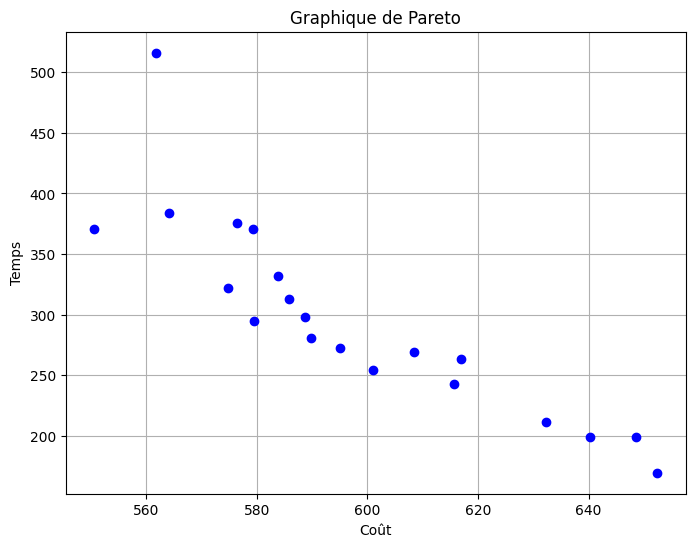

In [9]:
a = 0
start_time = time.time()
while a < 15:
    p = 0.25
    NP1 = deepcopy(Monarch1)
    NP2 = deepcopy(Monarch2)
    migration_operator(NP1, NP2, p)
    adjusting_operator(NP1, NP2, p)
    AllMonarchs = NP1 + NP2 + Population
    UnsortedMonarchs = deepcopy(AllMonarchs)
    Population = []
    while len(Population) < 20:
        # tant que la population n'est pas pleine, appeler la fonction de tri pour extirper les monarques les moins dominés 
        Front, UnsortedMonarchs = domination_sort(UnsortedMonarchs)
        Population += Front
    Population = Population[:20]
    Monarch1 = Population[:10]
    Monarch2 = Population[10:]
    a+=1
end_time = time.time()

elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

cost_pareto = []
time_pareto = []
for i in (Population):
    cost_pareto.append(cost(i))
    time_pareto.append(delay(i))

# Tracez le graphique de Pareto avec les points individuels
plt.figure(figsize=(8, 6))
plt.plot(cost_pareto, time_pareto, marker='o', linestyle='', color='b')  # En absisse le coût et en ordonnée le temps
plt.title('Graphique de Pareto')
plt.xlabel('Coût')
plt.ylabel('Temps')
plt.grid(True)
plt.show()

# Conclusion

Le monarch permet de généré des front pareto de manière assez hasardeuse, il y a beaucoup de chance d'obtenir des regroupement par minimum locaux. De plus un pareto assez représentatif est meilleur avec 15 itérations de l'algorithme et un paramètre de copie p des meilleurs solutions à 0.25. L'algorithme met environ 3.6 secondes, soit plus que le levy flight.